In [1]:
import os
import sys
import rootpath
sys.path.append(rootpath.detect())
import pickle
from testsuite.utilities import Pareto_split
import numpy as np
from testsuite.analysis import load_all, plot_all_pareto_3d, PLOT_STYLE, plot_measure
import matplotlib.pyplot as plt

In [2]:
dir_path = os.getcwd()
result_dirs = sorted(os.listdir("./log_data/"))
result_dirs

['test_function_Saf_Saf_init10_MultiSurrogate_ei',
 'test_function_Saf_Sms_init10_MultiSurrogate_mean',
 'test_function_Saf_init10_MultiSurrogate_GP_ei',
 'test_function_Saf_init10_MultiSurrogate_GP_mean',
 'test_function_SmsEgo_init10_MultiSurrogate_GP_ei',
 'test_function_SmsEgo_init10_MultiSurrogate_GP_mean',
 'test_function_Sms_Saf_init10_MultiSurrogate_mean']

In [22]:
try: 
    safsaf_results = np.load("./pkl_data/safsaf_results.pkl.npy")
    safsms_results = np.load("./pkl_data/safsms_results.pkl.npy")
    saf_ei_results = np.load("./pkl_data/saf_ei_results.pkl.npy")
    saf_mu_results = np.load("./pkl_data/saf_mu_results.pkl.npy")
    sms_ei_results = np.load("./pkl_data/sms_ei_results.pkl.npy")
    sms_mu_results = np.load("./pkl_data/sms_mu_results.pkl.npy")
    smssaf_results = np.load("./pkl_data/smssaf_results.pkl.npy")
except:
    raise AttributeError
    safsaf_results = load_all(os.path.join(dir_path, "log_data/", result_dirs[0]))
    safsms_results = load_all(os.path.join(dir_path, "log_data/", result_dirs[1]))
    saf_ei_results = load_all(os.path.join(dir_path, "log_data/", result_dirs[2]))
    saf_mu_results = load_all(os.path.join(dir_path, "log_data/", result_dirs[3]))
    sms_ei_results = load_all(os.path.join(dir_path, "log_data/", result_dirs[4]))
    sms_mu_results = load_all(os.path.join(dir_path, "log_data/", result_dirs[5]))
    smssaf_results = load_all(os.path.join(dir_path, "log_data/", result_dirs[6]))

AttributeError: 

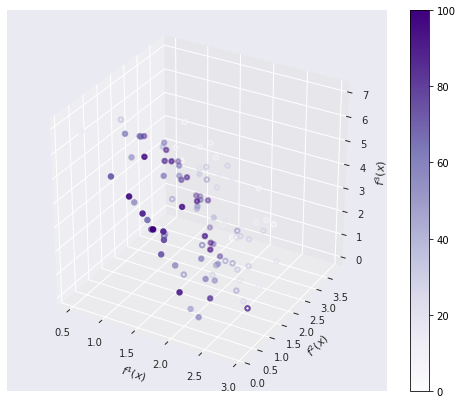

In [4]:
fig_smsmu = plot_all_pareto_3d(sms_mu_results, plot_indices=[0])

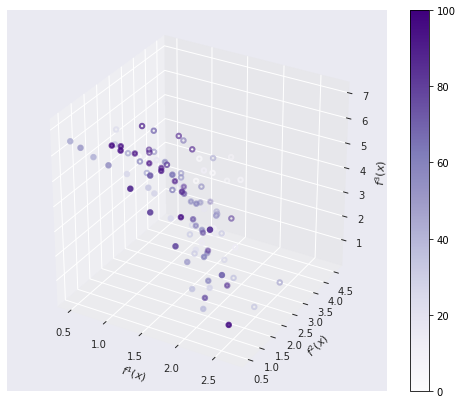

In [25]:
fig_smsmei= plot_all_pareto_3d(sms_ei_results, plot_indices=[0])

In [5]:
import wfg
N= 500

## establish objective function
kfactor = 1
lfactor = 2 
M = 5 # number of "underlying positional parameters" +1 
k = kfactor*(M-1) # position related parameers (must be devisible by M-1)
l = lfactor*2 # distance-related parameters, muist be even for WFG2 & WFG3
l = 3

n_obj = 3 # must be from 1:M 
n_dim = l+k

x_limits = np.zeros((2, n_dim))
x_limits[1] = np.array(range(1,n_dim+1))*2

# fun = BM.wfg
func =wfg.WFG6
args = [k, n_obj] # number of objectives as argument

y = np.zeros((N, n_obj))
for n in range(N):
    z = wfg.random_soln(k, l, func.__name__)
    y[n,:] = func(z, k, n_obj)

In [6]:
from pymoo.factory import get_performance_indicator

In [7]:
def extract_performance(z, indicator):
    ANS  = []
    for i in range(9, len(z)):
        ans = indicator.calc(z[:i])
        ANS.append(ans)

    return ANS

In [8]:
results = [safsaf_results, safsms_results, saf_ei_results, saf_mu_results, sms_ei_results, sms_mu_results, smssaf_results]
ref = np.array([result["y"] for result in results]).reshape(-1, n_obj).max(axis=0)

In [9]:
igdp = get_performance_indicator("igd+", y)
hv = get_performance_indicator("hv", ref_point=ref)
ref_v = hv.calc(np.zeros_like(ref))


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.configuration import Configuration
Configuration.show_compile_hint = False



In [10]:
import lhsmdu
lhs_x =np.array(lhsmdu.sample(numDimensions=n_dim, numSamples=100)).T*x_limits[1]
lhs_y = np.array([func(z, k, n_obj) for z in lhs_x])

In [11]:
lhslhs_results = {"y": lhs_y,
                 "x": lhs_x}

lhslhs_results["n_initial"] = safsaf_results['n_initial'][0]
lhslhs_results["hypervolume"] = hv.calc(lhslhs_results["y"])
lhslhs_results["igd"] = igdp.calc(lhslhs_results["y"])

In [12]:
print(lhslhs_results['hypervolume'])
print(lhslhs_results['igd'])
print(lhslhs_results['n_initial'])

40.07032644457233
0.6076019290328966
10


In [13]:
safsaf_results['igd'] = [extract_performance(safsaf_results["y"][i], igdp) for i in range(len(safsaf_results["y"]))]
safsms_results['igd'] = [extract_performance(safsms_results["y"][i], igdp) for i in range(len(safsms_results["y"]))]
saf_ei_results['igd'] = [extract_performance(saf_ei_results["y"][i], igdp) for i in range(len(saf_ei_results["y"]))]
saf_mu_results['igd'] = [extract_performance(saf_mu_results["y"][i], igdp) for i in range(len(saf_mu_results["y"]))]
sms_ei_results['igd'] = [extract_performance(sms_ei_results["y"][i], igdp) for i in range(len(sms_ei_results["y"]))]
sms_mu_results['igd'] = [extract_performance(sms_mu_results["y"][i], igdp) for i in range(len(sms_mu_results["y"]))]
smssaf_results['igd'] = [extract_performance(smssaf_results["y"][i], igdp) for i in range(len(smssaf_results["y"]))]
# lhslhs_results['igd'] = [extract_performance(lhslhs_results["y"][i], igdp) for i in range(len(smssaf_results["y"]))]

In [16]:
safsaf_results['hypervolume'] = [extract_performance(safsaf_results["y"][i], hv)/ref_v for i in range(len(safsaf_results["y"]))]
safsms_results['hypervolume'] = [extract_performance(safsms_results["y"][i], hv)/ref_v for i in range(len(safsms_results["y"]))]
saf_ei_results['hypervolume'] = [extract_performance(saf_ei_results["y"][i], hv)/ref_v for i in range(len(saf_ei_results["y"]))]
saf_mu_results['hypervolume'] = [extract_performance(saf_mu_results["y"][i], hv)/ref_v for i in range(len(saf_mu_results["y"]))]
sms_ei_results['hypervolume'] = [extract_performance(sms_ei_results["y"][i], hv)/ref_v for i in range(len(sms_ei_results["y"]))]
sms_mu_results['hypervolume'] = [extract_performance(sms_mu_results["y"][i], hv)/ref_v for i in range(len(sms_mu_results["y"]))]
smssaf_results['hypervolume'] = [extract_performance(smssaf_results["y"][i], hv)/ref_v for i in range(len(smssaf_results["y"]))]
# lhslhs_results['hypervolumevolume'] = [extract_performance(lhslhs_results["y"][i], hv) for i in range(len(smssaf_results["y"]))]

In [35]:
# safsaf_results['hypervolume'] = safsaf_results['hypervolume']/ref_v
# safsms_results['hypervolume'] = safsms_results['hypervolume']/ref_v
# saf_ei_results['hypervolume'] = saf_ei_results['hypervolume']/ref_v
# saf_mu_results['hypervolume'] = saf_mu_results['hypervolume']/ref_v
# sms_ei_results['hypervolume'] = sms_ei_results['hypervolume']/ref_v
# sms_mu_results['hypervolume'] = sms_mu_results['hypervolume']/ref_v
# smssaf_results['hypervolume'] = smssaf_results['hypervolume']/ref_v

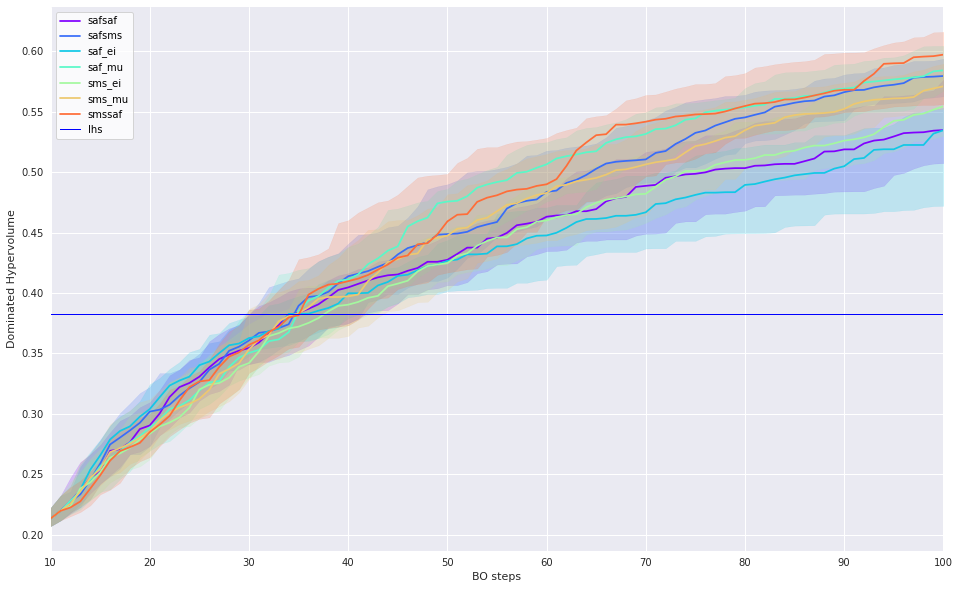

In [17]:
with plt.style.context(PLOT_STYLE["plot_style"]):
    fig_hv = plt.figure(figsize=[16, 10])
    ax_hv = fig_hv.gca()

cmap = PLOT_STYLE['plot_cmap']
colors = cmap(np.linspace(0, 1, len(result_dirs)+1))

plot_measure(safsaf_results, measure="hypervolume", axis=ax_hv, plot_individuals=False, label="safsaf", color=colors[0])
plot_measure(safsms_results, measure="hypervolume", axis=ax_hv, plot_individuals=False, label="safsms", color=colors[1])
plot_measure(saf_ei_results, measure="hypervolume", axis=ax_hv, plot_individuals=False, label="saf_ei", color=colors[2])
plot_measure(saf_mu_results, measure="hypervolume", axis=ax_hv, plot_individuals=False, label="saf_mu", color=colors[3])
plot_measure(sms_ei_results, measure="hypervolume", axis=ax_hv, plot_individuals=False, label="sms_ei", color=colors[4])
plot_measure(sms_mu_results, measure="hypervolume", axis=ax_hv, plot_individuals=False, label="sms_mu", color=colors[5])
plot_measure(smssaf_results, measure="hypervolume", axis=ax_hv, plot_individuals=False, label="smssaf", color=colors[6])
ax_hv.axhline(lhslhs_results["hypervolume"]/ref_v, linewidth=1, color="b", label="lhs")
ax_hv.set_xlim([10, 100])
ax_hv.set_xlabel("BO steps")
ax_hv.set_ylabel("Dominated Hypervolume")
ax_hv.legend()

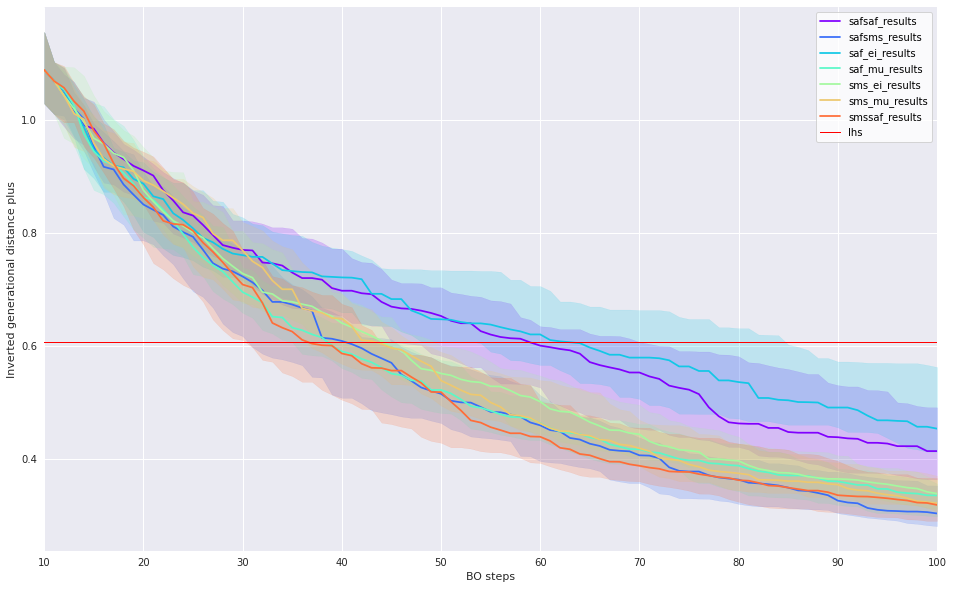

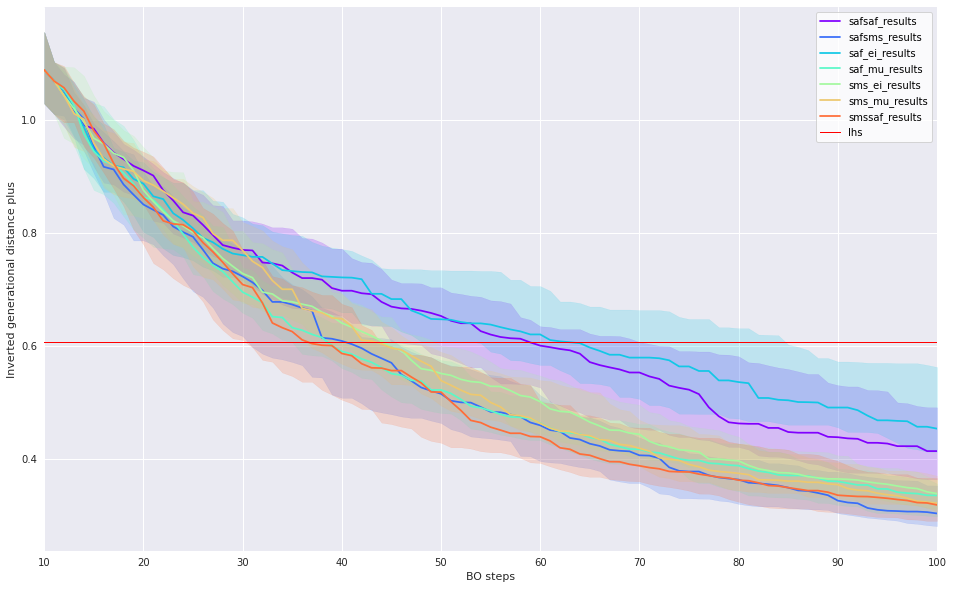

In [14]:
with plt.style.context(PLOT_STYLE["plot_style"]):
    fig_hv = plt.figure(figsize=[16, 10])
    ax_hv = fig_hv.gca()

cmap = PLOT_STYLE['plot_cmap']
colors = cmap(np.linspace(0, 1, len(result_dirs)+1))

plot_measure(safsaf_results, measure="igd", axis=ax_hv, plot_individuals=False, label="safsaf_results", color=colors[0])
plot_measure(safsms_results, measure="igd", axis=ax_hv, plot_individuals=False, label="safsms_results", color=colors[1])
plot_measure(saf_ei_results, measure="igd", axis=ax_hv, plot_individuals=False, label="saf_ei_results", color=colors[2])
plot_measure(saf_mu_results, measure="igd", axis=ax_hv, plot_individuals=False, label="saf_mu_results", color=colors[3])
plot_measure(sms_ei_results, measure="igd", axis=ax_hv, plot_individuals=False, label="sms_ei_results", color=colors[4])
plot_measure(sms_mu_results, measure="igd", axis=ax_hv, plot_individuals=False, label="sms_mu_results", color=colors[5])
plot_measure(smssaf_results, measure="igd", axis=ax_hv, plot_individuals=False, label="smssaf_results", color=colors[6])
ax_hv.axhline(lhslhs_results["igd"], linewidth=1, color="r", label="lhs")
# ax_hv.axhline(lhslhs_results["igd"][0], xmin=10, xmax=100, c=colors[7], label="lhs")

ax_hv.set_xlim([10, 100])
ax_hv.set_xlabel("BO steps")
ax_hv.set_ylabel("Inverted generational distance plus")
ax_hv.legend()
fig_hv

In [18]:
print(np.sum([len(errors) for errors in safsaf_results["errors"]]), "\t",*[errors for errors in safsaf_results["errors"] if len(errors)>0])
print(np.sum([len(errors) for errors in safsms_results["errors"]]), "\t",*[errors for errors in safsms_results["errors"] if len(errors)>0])
print(np.sum([len(errors) for errors in saf_ei_results["errors"]]), "\t",*[errors for errors in saf_ei_results["errors"] if len(errors)>0])
print(np.sum([len(errors) for errors in saf_mu_results["errors"]]), "\t",*[errors for errors in saf_mu_results["errors"] if len(errors)>0])
print(np.sum([len(errors) for errors in sms_ei_results["errors"]]), "\t",*[errors for errors in sms_ei_results["errors"] if len(errors)>0])
print(np.sum([len(errors) for errors in sms_mu_results["errors"]]), "\t",*[errors for errors in sms_mu_results["errors"] if len(errors)>0])
print(np.sum([len(errors) for errors in smssaf_results["errors"]]), "\t",*[errors for errors in smssaf_results["errors"] if len(errors)>0])

0 	
0 	
0 	
0 	
0 	
0 	
0 	


In [19]:
np.save("./pkl_results/safsaf_results.pkl", safsaf_results) 
np.save("./pkl_results/safsms_results.pkl", safsms_results) 
np.save("./pkl_results/saf_ei_results.pkl", saf_ei_results) 
np.save("./pkl_results/saf_mu_results.pkl", saf_mu_results) 
np.save("./pkl_results/sms_ei_results.pkl", sms_ei_results) 
np.save("./pkl_results/sms_mu_results.pkl", sms_mu_results) 
np.save("./pkl_results/smssaf_results.pkl", smssaf_results) 

In [37]:
ref.shape

(5,)